In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths

In [17]:
def ViewPulses(filelocation, events, XRange, preTrgrDly):
    with h5py.File(filelocation, 'r') as f:
        for a in range(events):
            pulse = np.array(f['raw_data'][a, :XRange])  # type: ignore
            baseline = np.average(pulse[:preTrgrDly-100])
            pulse = pulse - baseline
            plt.plot(pulse[preTrgrDly-100:])

def CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime):
    with h5py.File(filelocation, 'r') as f:
        spectra = []
        for a in range(events):
            pulse = np.array(f['raw_data'][a, :XRange])  # type: ignore
            baseline = np.average(pulse[:preTrgrDly-100])
            pulse = pulse - baseline
            sum = np.sum(pulse[preTrgrDly-100:preTrgrDly+risetime])
            if sum > 0:
                spectra.append(sum)
        return(spectra)

def Gaussian(x, a, center, sigma, d):
    return a*np.exp(-(x-center)**2/(2*sigma**2))+d

def PeakInfo(hist, d, promF):
    peaklocations, _ = find_peaks(hist, distance=d, prominence=int(np.amax(hist))/promF)
    widths = peak_widths(hist, peaklocations, rel_height=0.5)
    Xranges = []
    coefficients = []
    numberofpeaks = 0
    FWHMs = []
    for i in range(len(peaklocations)):
        try:
            left = int(peaklocations[i]-widths[0][i])
            right = int(peaklocations[i]+widths[0][i])
            x = np.linspace(left, right, right-left)
            popt, pcov = curve_fit(Gaussian, x, hist[left:right], [hist[peaklocations[i]], peaklocations[i], widths[0][i], 0])
            popt[2] = np.abs(popt[2])
            Xranges.append(x)
            coefficients.append(popt)
            numberofpeaks += 1
            FWHMs.append(widths[0][i])
        except:
            pass
    return Xranges, coefficients, numberofpeaks, FWHMs


Specifying that counts start 100 before trigger (preTrgrDly-100)

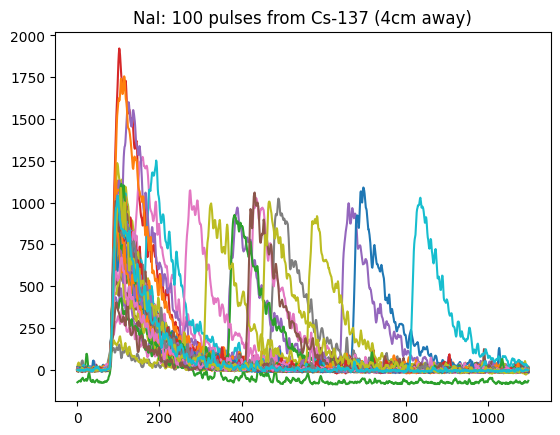

In [18]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_4cm_30.h5"
events = 50
XRange = 5000
preTrgrDly = 1000
ViewPulses(filelocation, events, XRange, preTrgrDly)
plt.title('NaI: 50 pulses from Cs-137 (4cm away)')
plt.show()

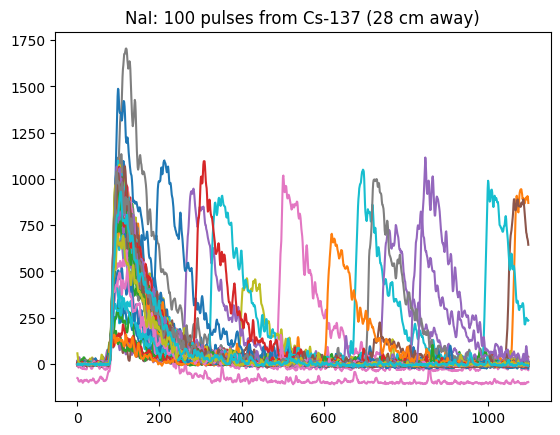

In [19]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_28cm_30.h5"
events = 50
XRange = 5000
preTrgrDly = 1000
ViewPulses(filelocation, events, XRange, preTrgrDly)
plt.title('NaI: 50 pulses from Cs-137 (28 cm away)')
plt.show()

The initial pulses generally decay by about 400 counts in (1.6 microseconds). Don't see much of a difference in pile-up rate between 4 and 28 cm away however.

Centroid is at: 423.3867952814466
FWHM is: 24.983586226661977
% Resolution = 5.900889329827615
Centroid is at: 471.83161405671865
FWHM is: 25.14614280577782
% Resolution = 5.329473917522409


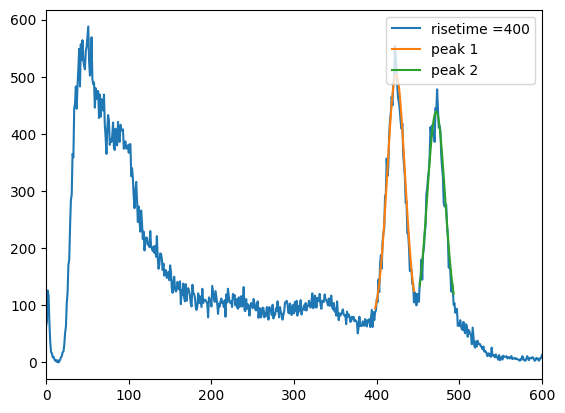

In [20]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Co60_120s.h5"
events = 100000
XRange = 2000
preTrgrDly = 1000
peakdistance = 10
prominencefactor = 2

risetime = 400

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)

hist, bins = np.histogram(spectra, bins = 5000)
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))

Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))

plt.legend(loc='upper right')
plt.xlim(0, 600)
plt.show()

Centroid is at: 66.76834531219752
FWHM is: 8.960207784231283
% Resolution = 13.419844002925132
Centroid is at: 173.71561489248808
FWHM is: 17.81739826328465
% Resolution = 10.256647494994487


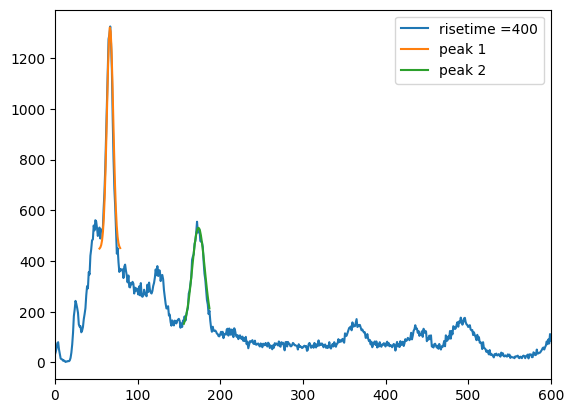

In [21]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Eu152_120s.h5"
events = 100000
XRange = 2000
preTrgrDly = 1000
peakdistance = 10
prominencefactor = 8

risetime = 400

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)

hist, bins = np.histogram(spectra, bins = 5000)
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))

Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))

plt.legend(loc='upper right')
plt.xlim(0, 600)
plt.show()

Centroid is at: 94.68389120673987
FWHM is: 413.0272152099397
% Resolution = 436.21698469078046
Centroid is at: 249.52440457531654
FWHM is: 21.364298521220938
% Resolution = 8.562007615079724
Centroid is at: 559.7075925350784
FWHM is: 32.60722818292822
% Resolution = 5.825761275676215


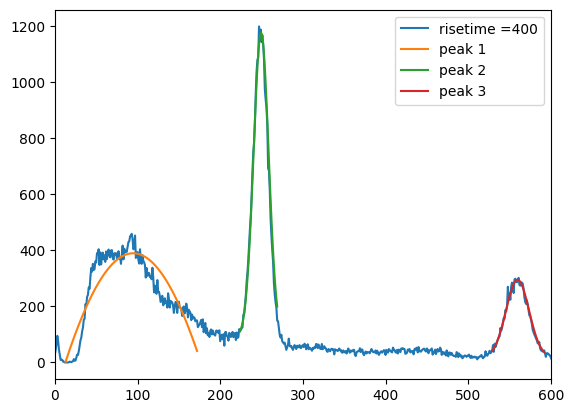

In [22]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Na22_120s.h5"
events = 100000
XRange = 2000
preTrgrDly = 1000
peakdistance = 10
prominencefactor = 5

risetime = 400

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)

hist, bins = np.histogram(spectra, bins = 5000)
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))

Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))

plt.legend(loc='upper right')
plt.xlim(0, 600)
plt.show()

Centroid is at: 51.160766621098176
FWHM is: 8.601706274031596
% Resolution = 16.81309105028997
Centroid is at: 199.64978846604404
FWHM is: 17.935129094380137
% Resolution = 8.983294814474847


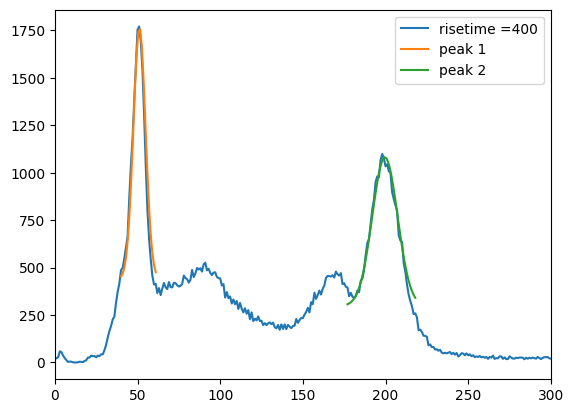

In [23]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Ba133_120s.h5"
events = 100000
XRange = 2000
preTrgrDly = 1000
peakdistance = 10
prominencefactor = 4

risetime = 400

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)

hist, bins = np.histogram(spectra, bins = 5000)
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))

Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))

plt.legend(loc='upper right')
plt.xlim(0, 300)
plt.show()

Centroid is at: 389.17069558884737
FWHM is: 28.80323917077563
% Resolution = 7.401183978458078


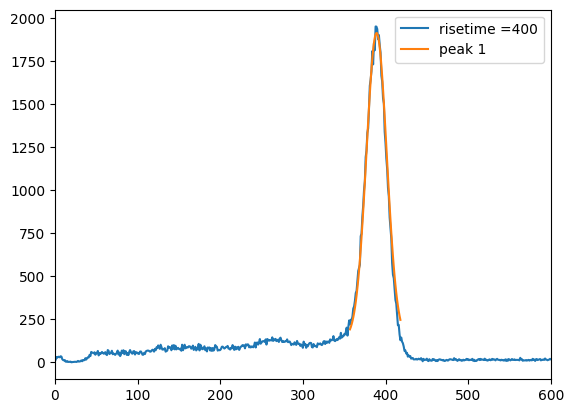

In [24]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_4cm_30.h5"
events = 100000
XRange = 2000
preTrgrDly = 1000
peakdistance = 10
prominencefactor = 2

risetime = 400

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)

hist, bins = np.histogram(spectra, bins = 5000)
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))

Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))

plt.legend(loc='upper right')
plt.xlim(0, 600)
plt.show()

Centroid is at: 369.14243014523214
FWHM is: 27.90351921927778
% Resolution = 7.559011628194479


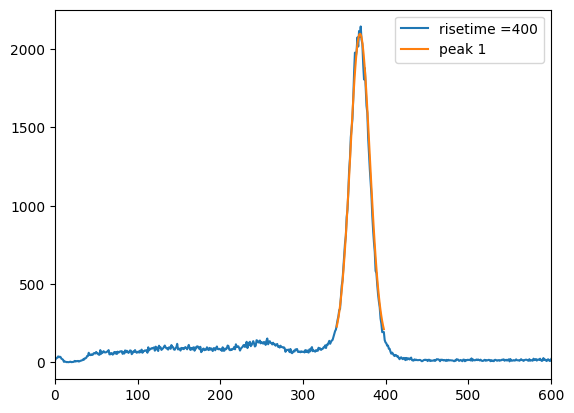

In [39]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_28cm_30.h5"
events = 100000
XRange = 2000
preTrgrDly = 1000
peakdistance = 10
prominencefactor = 2

risetime = 400

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)

hist, bins = np.histogram(spectra, bins = 5000)
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))

Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))

plt.legend(loc='upper right')
plt.xlim(0, 600)
plt.show()

In [38]:
filelocations = [
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_4cm_30.h5", 
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_8cm_30.h5", 
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_12cm_30.h5",
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_16cm_30.h5",
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_20cm_30.h5",
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_24cm_30.h5",
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_28cm_30.h5",
    ]

data = []
for a in filelocations:
    row = []
    filelocation = a
    events = 100000
    XRange = 2000
    preTrgrDly = 1000
    peakdistance = 10
    prominencefactor = 2
    for b in range(9):
        resolutions = []
        risetime = 100*(b+1)
        spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)
        hist, bins = np.histogram(spectra, bins = 5000)
        Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
        for i in range(numberofpeaks):
            resolutions.append(100*2.35*coefficients[i][2]/coefficients[i][1])
        row.append(np.average(resolutions))    
    data.append(row)

df = pd.DataFrame(data, index=range(len(filelocations)), columns=100*(np.array(range(9))+1))
df.style.background_gradient(axis=None)



,100,200,300,400,500,600,700,800,900
0,7.733619,7.736581,7.560226,7.401184,7.421693,7.560841,8.000002,8.063193,8.150337
1,7.749341,7.525379,7.543742,7.510849,7.621952,7.584815,7.687577,7.766655,7.857816
2,7.578810,7.427406,7.435736,7.531356,7.631565,7.606793,7.766623,7.784581,8.040322
3,7.549275,7.499468,7.476484,7.555737,7.507413,7.603900,7.784533,7.907087,7.944138
4,7.902294,7.525524,7.350576,7.379439,7.630615,7.541538,7.661468,7.870269,7.812647
5,7.803292,7.659500,7.639813,7.701940,7.678243,7.739097,7.841451,7.893150,8.013384
6,7.769139,7.491781,7.462981,7.559012,7.569737,7.598410,7.720771,7.800653,7.842139
